# Synapse Clustering 
*Author Youngser Park*

*Continued by Jesse Patsolic*


#### Table of Contents

1. [Introduction](#1-Introduction)

2. [Data](#2-Data)

3. [Using integrated brightness features only](#3-Using-integrated-brightness-features-only)

    3.1. [Level 1](#3.1-Level-1)

4. [Using integrated brightness features without other and none](#4-Using-integrated-brightness-features-without-other-and-none)
    
 

# 1 Introduction

> On Fri, Dec 11, 2015 at 11:53 AM, joshua vogelstein <jovo@jhu.edu> wrote:  
> we will get n=10^6 points, each in d=25 dimensions.  
> i want to hierarchically cluster them, in a ways:  

1. recursive k-means on the data, maybe 5 levels
2. compute approximate k-neighbors, svd in d=dimensions, and then #1
3. maybe some other ways.


## To turn on scatterplots set showPlots to TRUE

In [1]:
showPlots <- FALSE

In [2]:
## Loading required libraries
suppressMessages(require(Matrix))
suppressMessages(require(colorRamps))
suppressMessages(require(corrplot))
suppressMessages(require(gplots))
suppressMessages(require(dplyr))
suppressMessages(require(reshape2))
suppressMessages(require(ggplot2))
suppressMessages(require(parallel))
suppressMessages(require(data.table))
suppressMessages(require(fpc))
suppressMessages(require(repr))

# Change plot size to 5 x 5
options(repr.plot.width=5, repr.plot.height=5)

# must be loaded everytime idt is called!!
sourceUserFunctions <- function()
{
    con1 <- c("http://www.cis.jhu.edu/~parky/Synapse/getElbows.R")
    con2 <- c("http://www.cis.jhu.edu/~parky/Synapse/doidt.r")
    source(con1)
    source(con2)
}

sourceUserFunctions()

In [3]:
feat <- fread("../Data/synapsinR_7thA.tif.Pivots.txt.2011Features.txt",showProgress=FALSE)
dim(feat)
channel <- c('Synap','Synap','VGlut1','VGlut1','VGlut2','Vglut3',
              'psd','glur2','nmdar1','nr2b','gad','VGAT',
              'PV','Gephyr','GABAR1','GABABR','CR1','5HT1A',
              'NOS','TH','VACht','Synapo','tubuli','DAPI')
channel.type <- c('ex.pre','ex.pre','ex.pre','ex.pre','ex.pre','in.pre.small',
                  'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre',
                  'in.pre','in.post','in.post','in.post','in.pre.small','other',
                  'ex.post','other','other','ex.post','none','none')
nchannel <- length(channel)
nfeat <- ncol(feat) / nchannel
fchannel <- as.numeric(as.factor(channel.type))
ccol <- rainbow(max(fchannel))[fchannel]


[1] 1119299     144

# 2 Data

#### This corresponds to 24 channels x 6 features per synapse, ordered like c0f0,c0f1,c0f2,c0f3,c0f4,c0f5,c1f0,c1f1... etc

- f0 = integrated brightness
- f1 = local brightness
- f2 = distance to Center of Mass
- f3 = moment of inertia around synapsin maxima
- f4,f5 are features that I forget what they are.. would need to ask brad. I would throw them out, I did so in my kohonen code (which you have, its in matlab).

#### and

> On Feb 8, 2016, at 2:00 PM, Kristina Micheva <kmicheva@stanford.edu> wrote:

* <FONT COLOR="red">_Excitatory presynaptic: 'Synap', 'Synap', 'VGlut1', 'VGlut1', 'VGlut2'_</FONT>,
* <FONT COLOR="gold">_Excitatory postsynaptic: 'psd', 'glur2', 'nmdar1', 'nr2b', 'NOS', 'Synapo'_</FONT> (but further away than PSD, gluR2, nmdar1 and nr2b)
* <FONT COLOR="green">_Inhibitory presynaptic: 'gad', 'VGAT', 'PV'_</FONT>,
* <FONT COLOR="springgreen">_Inhibitory postsynaptic: 'Gephyr', 'GABAR1', 'GABABR', 'NOS'_</FONT>,
* <FONT COLOR="deepskyblue">_At a very small number of inhibitory: 'Vglut3' (presynaptic), 'CR1'(presynaptic)_</FONT>,
* <FONT COLOR="mediumblue">_Other synapses:'5HT1A', 'TH', 'VACht'_</FONT>,
* <FONT COLOR="magenta">_Not at synapses: 'tubuli', 'DAPI'_</FONT>.


In [4]:
fname <- as.vector(sapply(channel,function(x) paste0(x,1:6)))
names(feat) <- fname
fcol <- rep(ccol, each=6)
mycol <- colorpanel(100,"blue","grey","red")

# ignore f4,f5
f4 <- seq(5,ncol(feat),by=6)
f5 <- seq(6,ncol(feat),by=6)
#feat <- as.matrix(feat)[,-c(f4,f5)] 
feat <- subset(feat, select=-c(f4,f5))
nfeat <- ncol(feat) / nchannel


#### The following chunk was set to echo=FALSE



In [5]:
if(showPlots){
    #df <- melt(feat)
    #ggplot(df, aes(x=value)) + geom_density(aes(group=variable, colour=variable))
    mycol2 <- matlab.like(nchannel)
    suppressWarnings(plot(density(as.numeric(as.matrix(subset(feat,select=1))),from=0.000001),type="n",main="",log="xy",xlim=c(3e+6,3e+07)))
    for (i in 1:nchannel) {
        dat <- as.numeric(as.matrix(subset(feat,select=(i-1)*4+c(1:4))))
        suppressWarnings(lines(density(dat,from=0.000001),col=mycol2[i],log="xy"))
    }
    legend("topright",legend=channel,pch=19,col=mycol2,ncol=4,cex=0.7)
    }

#### The following chunk was set to echo = FALSE

number of leaves (clusters) =  69 


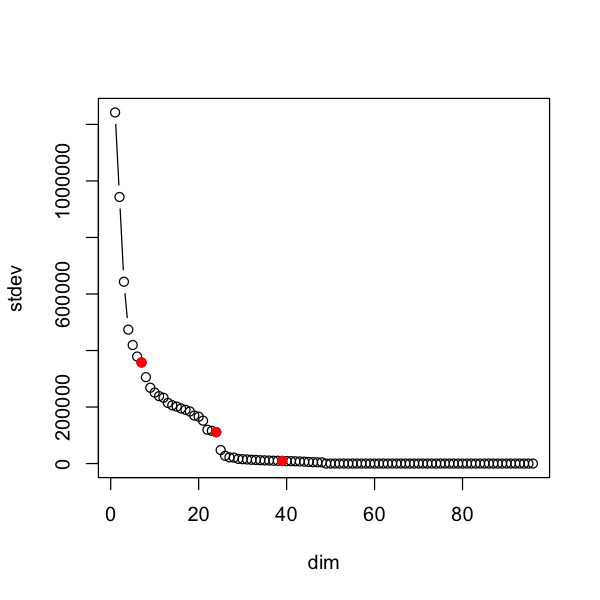

In [6]:
pr <- prcomp(feat,scale=FALSE)
elb <- getElbows(pr$x,3,plot=TRUE)
X <- pr$x[,1:elb[3]]

# idt
sourceUserFunctions()
out <- doIDT(as.matrix(X),
             FUN="pamk",
             Dmax=ncol(X),    # max dim for clustering
             Kmax=10,         # max K for clustering 
             maxsamp=nrow(X), # max n for clustering
             samp=1,          # 1: no sampling, else n/sample sampling
             maxdepth=5,      # termination, maximum depth for idt
             minnum=100)      # termination, minimum observations per branch 

#### This Rbin file doesn't seem to be generated.
#load("X-idt-d96-Kmax10-depth5-min100.Rbin")
#cat("number of leaves (clusters) = ",max(out$class),"\n")

In [7]:
idtlab <- out$class
#set.seed(2^13)
#plot(X[sample(dim(X)[1],1e4),], pch=".",col=idtlab)
#plot(X[sample(dim(X)[1],1e4),], pch=".",col=idtlab)

In [8]:
feat2 <- scale(feat,center=TRUE,scale=TRUE)
feat2 <- aggregate(feat2, by=list(lab=idtlab), FUN=mean)
feat2 <- feat2[,-1]
#image(Matrix(as.matrix(feat2)),lwd=0,aspect="fill")

# cluster rows and columns
#heatmap.2(as.matrix(feat2), trace="none", col=mycol, cexRow=0.2, cexCol=0.3, keysize=1, colCol=fcol,srtCol=90)

# 3 Using integrated brightness features only

> On Jan 19, 2016, at 11:54 AM, jovo Vogelstein <jovo@jhu.edu> wrote:  
> the channels have an arbitrary independent linear transform,  
> so doing pca on the raw data is fairly meaningless.  
> also, the 6 features are fundamentally different, they are even different units,  
> so it is difficult to understand linear combinations across features.  
> converting to z-scores, or quantiles, is required to make sense of the resulting data.  
> so, i'd start with: just look at the first 24 features, which are the "integrated brightness" for each of the channels,  and linearly transform to z-scores.  
> and then just do iterated k-means.  


Warning message:
: Removed 24091 rows containing non-finite values (stat_density).

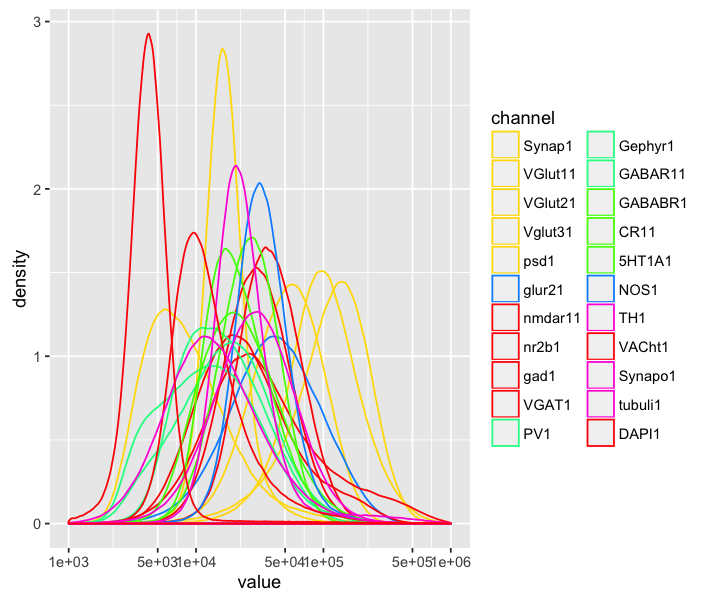

In [9]:
f0 <- seq(1,ncol(feat),by=nfeat)
feat3 <- as.matrix(feat)[,f0]
zfeat3 <- scale(feat3,center=TRUE,scale=TRUE)

#mycol2 <- matlab.like(nchannel)
df <- melt(feat3)
names(df) <- c("ind","channel","value")
options(repr.plot.width=6, repr.plot.height=5)
ggplot(df, aes(x=value)) + 
    scale_color_manual(values=ccol) +
    scale_x_log10(limits=c(1e+03,1e+06), breaks=c(1e+03,5e+03,1e+04,5e+04,1e+05,5e+05,1e+06))+
    geom_density(aes(group=channel, colour=channel))


[1]  3 18 21

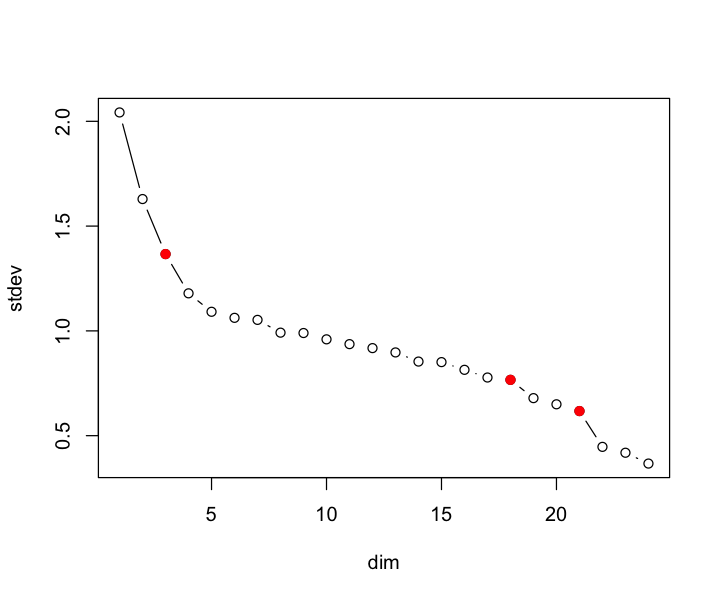

In [10]:
pr2 <- prcomp(zfeat3)
(elb <- getElbows(pr2$x,3,plot=TRUE))

In [11]:
X <- pr2$x[,1:elb[3]]
sourceUserFunctions()
out <- doIDT(as.matrix(X),
             FUN="pamk",
             Dmax=ncol(X), ## max dim for clustering
             Kmax=9,  ## max K for clustering 
             maxsamp=nrow(X), ## max n for clustering
             samp=1, # 1: no sampling, else n/sample sampling
             maxdepth=5, # termination, maximum depth for idt
             minnum=100, # termination, minimum observations per branch
             verbose=FALSE)  

number of leaves (clusters) =  194 


In [12]:
idtlab <- out$class

#### This line of code crashes jupyter;
#### the plot is too big.
#### So, I ran 2 samples of 10,000 instead. 
set.seed(2^13); 
#plot(X[sample(dim(X)[1],1e4),], pch=".",col=idtlab, main="1st sample")
#plot(X[sample(dim(X)[1],1e4),], pch=".",col=idtlab, main="2nd sample");
#print("Samples of scatter plot of IDT clustering.")

In [13]:
feat4 <- aggregate(zfeat3, by=list(lab=idtlab), FUN=mean)
feat4 <- feat4[,-1]
#image(Matrix(as.matrix(feat4)),lwd=0, aspect="fill")

# cluster rows and columns
options(repr.plot.width=7, repr.plot.height=7)

### Haven't figured out how to suppress the list of hex colors...
mycol <- colorpanel(100,"blue","grey","red")
#heatmap.2(as.matrix(feat4), trace="none", col=mycol, cexRow=0.5, keysize=1, colCol=ccol,srtCol=90)

print("Heapmap of the cluster means vs. channels. Rows and columns are rearranged according to hclust.")

[1] "Heapmap of the cluster means vs. channels. Rows and columns are rearranged according to hclust."


## 3.1 Level 1
#### cut tree at level 1


In [14]:
idtall <- out$idtall
ppp <- sapply(idtall, function(x) x$depth==2)
qqq <- which(ppp==TRUE)
tree1 <- idtall[qqq]
(n1 <- sapply(tree1, function(x) length(x$ids)))
lab1 <- rep(1:length(n1), times=n1)


[1] 709107 277157 126907   6128

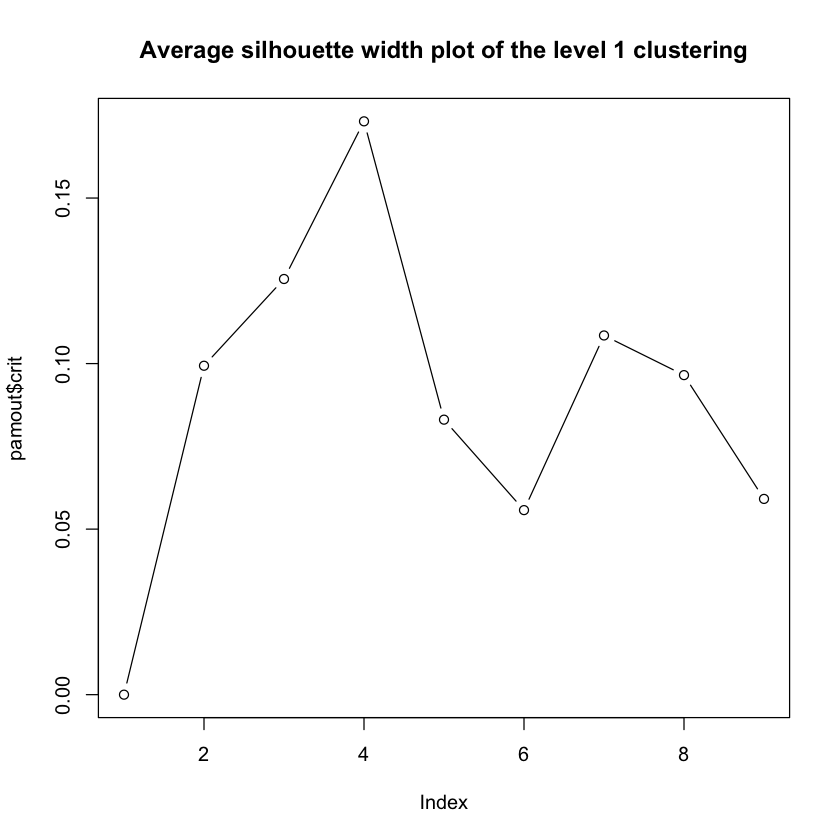

In [15]:
pr2 <- prcomp(X)
X2 <- pr2$x[,1:13]
set.seed(12346)
pamout <- pamk(X2,krange=1:9,usepam=FALSE,critout=FALSE)

mn1 <- "Average silhouette width plot of the level 1 clustering"
plot(pamout$crit,type="b", main=mn1)
### In this example, `idt` yields `r length(n1)` clusters 
### while `pamk` claims `r pamout$nc` clusters.

In [16]:
if(showPlots){
    set.seed(2^13)
    print("Sampled scatter plots of first level from the IDT clustering")
    plot(X[sample(dim(X)[1],1e4),], pch=".",col=lab1+1, main='sample 1')
    plot(X[sample(dim(X)[1],1e4),], pch=".",col=lab1+1, main='sample 2')
    }


In [17]:
if(showPlots){
    set.seed(2^13)
    pairs(X[sample(1e4),1:4],pch=".",col=lab1+1)
    }

 [1] "#FFDB00FF" "#FF0000FF" "#FFDB00FF" "#FFDB00FF" "#FF00DBFF" "#FF0000FF"
 [7] "#49FF00FF" "#FF0000FF" "#49FF00FF" "#FF0000FF" "#FFDB00FF" "#00FF92FF"
[13] "#4900FFFF" "#00FF92FF" "#00FF92FF" "#FF0000FF" "#49FF00FF" "#FF0000FF"
[19] "#0092FFFF" "#FF00DBFF" "#FFDB00FF" "#0092FFFF" "#4900FFFF" "#FF00DBFF"


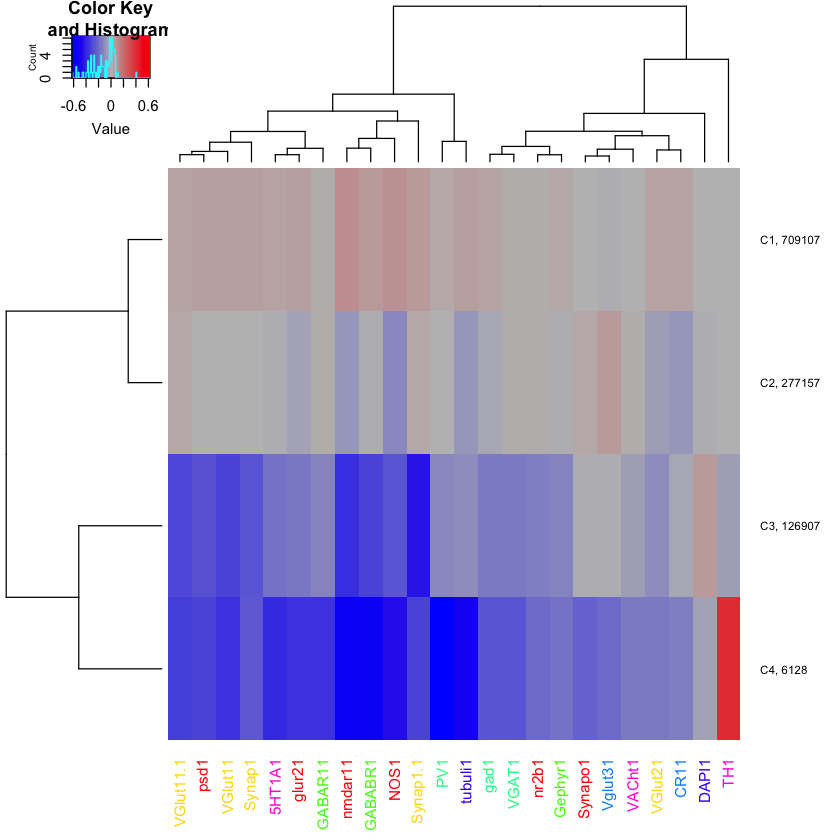

In [18]:
feat5 <- aggregate(zfeat3, by=list(lab=lab1), FUN=mean)
feat5 <- feat5[,-1]
rownames(feat5) <- paste0("C",1:length(n1),", ",n1)
#image(Matrix(as.matrix(feat4)),lwd=0, aspect="fill")

# cluster rows and columns
heatmap.2(as.matrix(feat5), trace="none", col=mycol, keysize=1, colCol=ccol,srtCol=90,cexRow=0.7)

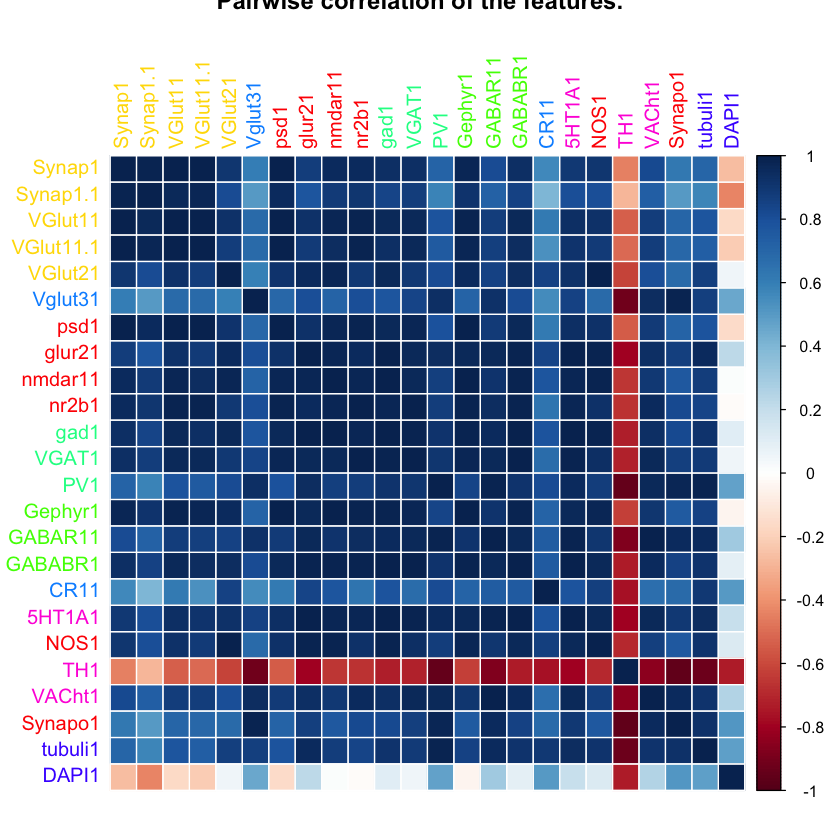

In [19]:
cmat <- cor(feat5)
mn2 <- "Pairwise correlation of the features."
corrplot(cmat,method="color",tl.col=ccol, title=mn2)


[1] "Reordered based on the synapse type."


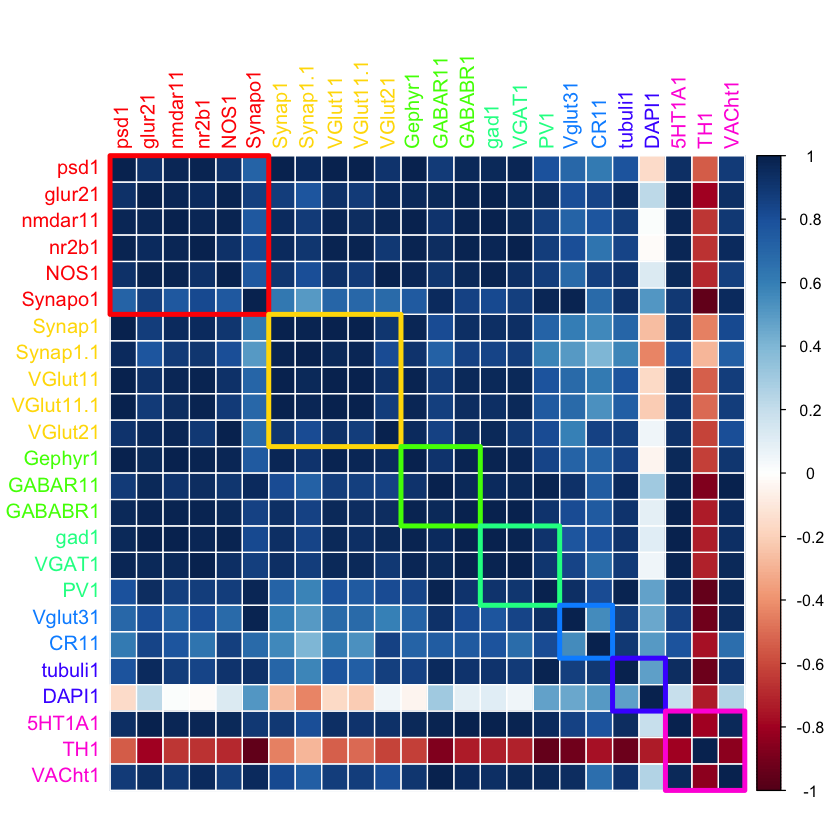

In [20]:
fchannel <- as.numeric(as.factor(channel.type))
fcol <- rainbow(max(fchannel))
ford <- order(fchannel)
tmp <- as.numeric(table(fchannel))
#plotmemb2(cmat,fchannel,lcol=lcol,lwdb=2)
corrplot(cmat[ford,ford],method="color",tl.col=ccol[ford])
corrRect(tmp,col=fcol,lwd=4)
print("Reordered based on the synapse type.")

# 4 Using integrated brightness features without other and none

- That is, using "integrated brightness" features (`f0`) only and without "other"={`5HT1A`,`TH`,`VACht`} and "none"={`tubuli`,`DAPI`} channels.


[1] "5HT1A"  "TH"     "VACht"  "tubuli" "DAPI"

[1]  3 14 16

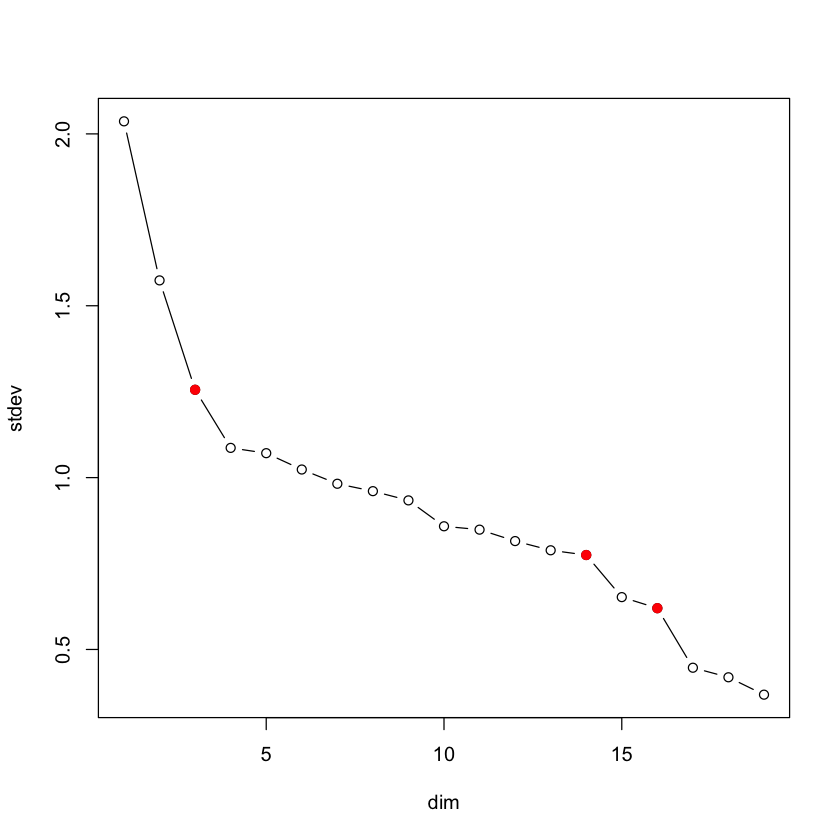

In [21]:
cuse <- channel.type %in% c("other","none")
channel.type2 <- channel.type[!cuse]
#fchannel <- as.numeric(as.factor(channel.type2))
fchannel <- fchannel[!cuse]
fcol <- fcol[sort(unique(fchannel))]
(nonsynapse <- channel[cuse])
nouse <- pmatch(nonsynapse,colnames(zfeat3))
zfeat4 <- zfeat3[,-nouse]
ccol <- ccol[-nouse] #rainbow(max(fchannel))[fchannel]

pr3 <- prcomp(zfeat4)
(elb <- getElbows(pr3$x,3,plot=TRUE))
X <- pr3$x[,1:elb[3]]


In [22]:
sourceUserFunctions()
out <- doIDT(as.matrix(X),
             FUN="pamk",
             Dmax=ncol(X),    # max dim for clustering
             Kmax=9,          # max K for clustering 
             maxsamp=nrow(X), # max n for clustering
             samp=1,          # 1: no sampling, else n/sample sampling
             maxdepth=5,      # termination, maximum depth for idt
             minnum=100,      # termination, minimum observations per branch
             verbose=FALSE)  

number of leaves (clusters) =  74 


In [23]:
idtlab <- out$class
if(showPlots){
    mn3 <- "Sample of scatter plot: IDT clustering."
    set.seed(2^13)
    plot(X[sample(dim(X)[1],1e4),], pch=".",col=idtlab, main=mn3)
    plot(X[sample(dim(X)[1],1e4),], pch=".",col=idtlab, main=mn3)
    }

 [1] "#0092FFFF" "#49FF00FF" "#49FF00FF" "#49FF00FF" "#FFDB00FF" "#0092FFFF"
 [7] "#FFDB00FF" "#FFDB00FF" "#FF0000FF" "#FF0000FF" "#FF0000FF" "#FF0000FF"
[13] "#FF0000FF" "#FF0000FF" "#FFDB00FF" "#FFDB00FF" "#00FF92FF" "#00FF92FF"
[19] "#00FF92FF"
[1] "Heatmap of the cluster means vs. channels. Rows and columns are rearranged according to hclust."


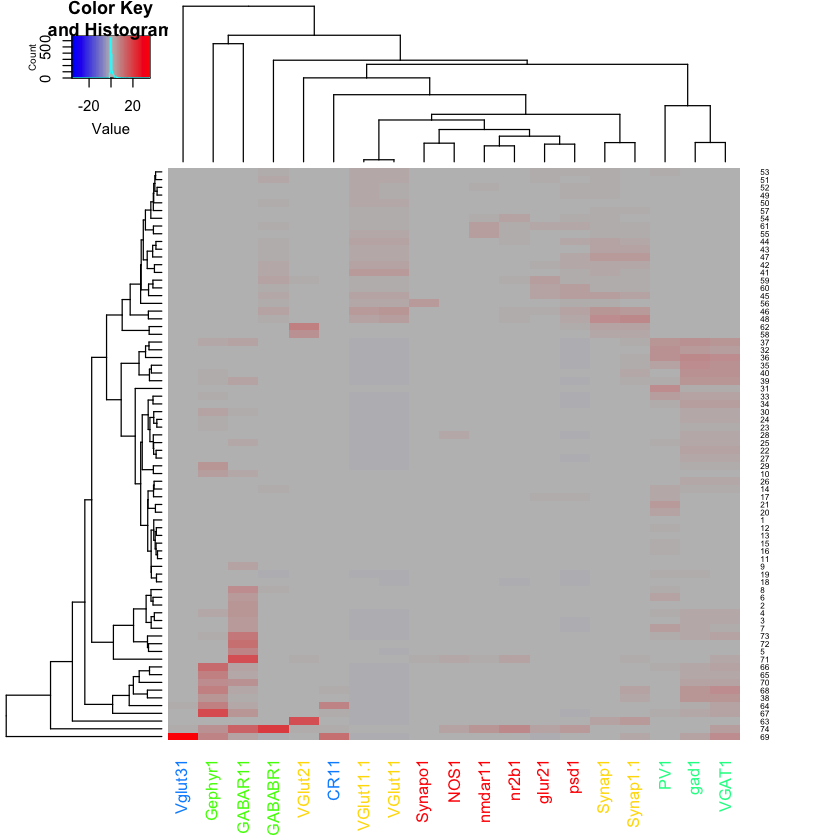

In [24]:
feat4 <- aggregate(zfeat4, by=list(lab=idtlab), FUN=mean)
feat4 <- feat4[,-1]
#image(Matrix(as.matrix(feat4)),lwd=0, aspect="fill")

# cluster rows and columns
heatmap.2(as.matrix(feat4), trace="none", col=mycol, cexRow=0.5, keysize=1, colCol=ccol,srtCol=90)
print("Heatmap of the cluster means vs. channels. Rows and columns are rearranged according to hclust.")


## 4.1 Level 1

In [25]:
# cut tree at level 1
idtall <- out$idtall
ppp <- sapply(idtall, function(x) x$depth==2)
qqq <- which(ppp==TRUE)
tree1 <- idtall[qqq]
(n1 <- sapply(tree1, function(x) length(x$ids)))
lab1 <- rep(1:length(n1), times=n1)


[1] 790708 150883 172509   5199

In [26]:
pr2 <- prcomp(X)
X2 <- pr2$x[,1:9] # elb[2]
set.seed(12346)
pamout <- pamk(X2,krange=1:9,usepam=FALSE,critout=FALSE)

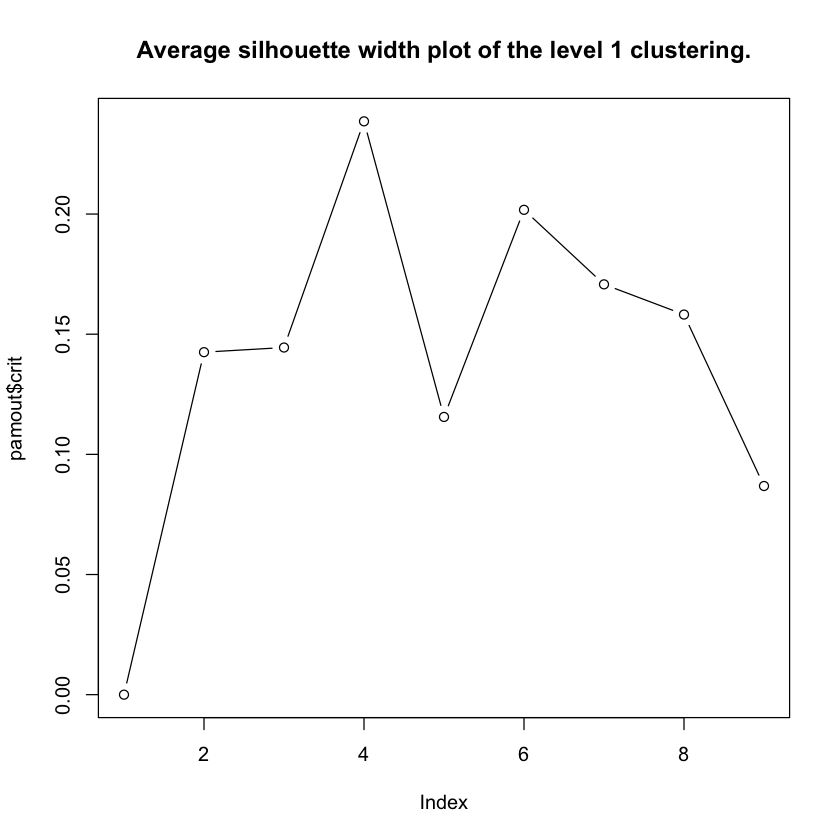

In [27]:
mn3 <- "Average silhouette width plot of the level 1 clustering."
plot(pamout$crit,type="b", main=mn3)

In [28]:
if(showPlots){
    mn4 <- "Scatter plot of first level from the IDT clustering."
    set.seed(2^13)
    plot(X[sample(dim(X)[1],1e4),], pch=".",col=lab1+1)
    plot(X[sample(dim(X)[1],1e4),], pch=".",col=lab1+1)
    }

In [29]:
feat5 <- aggregate(zfeat4, by=list(lab=lab1), FUN=mean)
feat5 <- feat5[,-1]
rownames(feat5) <- paste0("C",1:length(n1),", ",n1)

#### This chunk was set to echo=FALSE

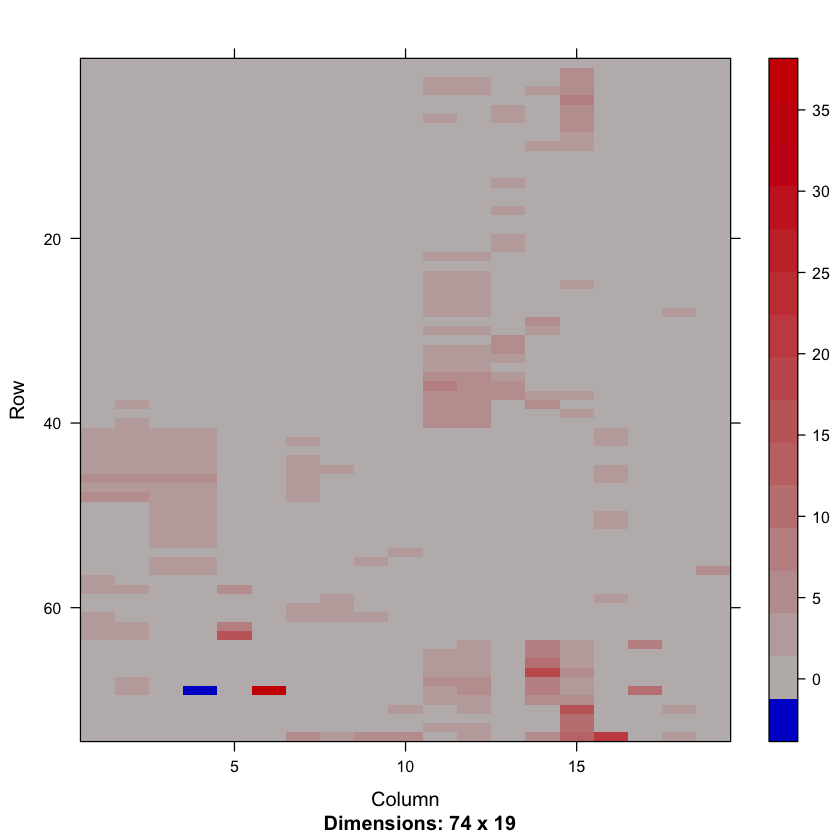

In [30]:
image(Matrix(as.matrix(feat4)),lwd=0, aspect="fill")

In [31]:
heatmap.2(as.matrix(feat5), trace="none", col=mycol, keysize=1,cexRow=0.7, colCol=ccol,srtCol=90,
          symm=F,symkey=F,symbreaks=F,scale="none")

 [1] "#00FF92FF" "#00FF92FF" "#FFDB00FF" "#FF0000FF" "#FF0000FF" "#49FF00FF"
 [7] "#49FF00FF" "#FFDB00FF" "#0092FFFF" "#FF0000FF" "#0092FFFF" "#FF0000FF"
[13] "#FFDB00FF" "#FFDB00FF" "#FFDB00FF" "#FF0000FF" "#49FF00FF" "#FF0000FF"
[19] "#00FF92FF"


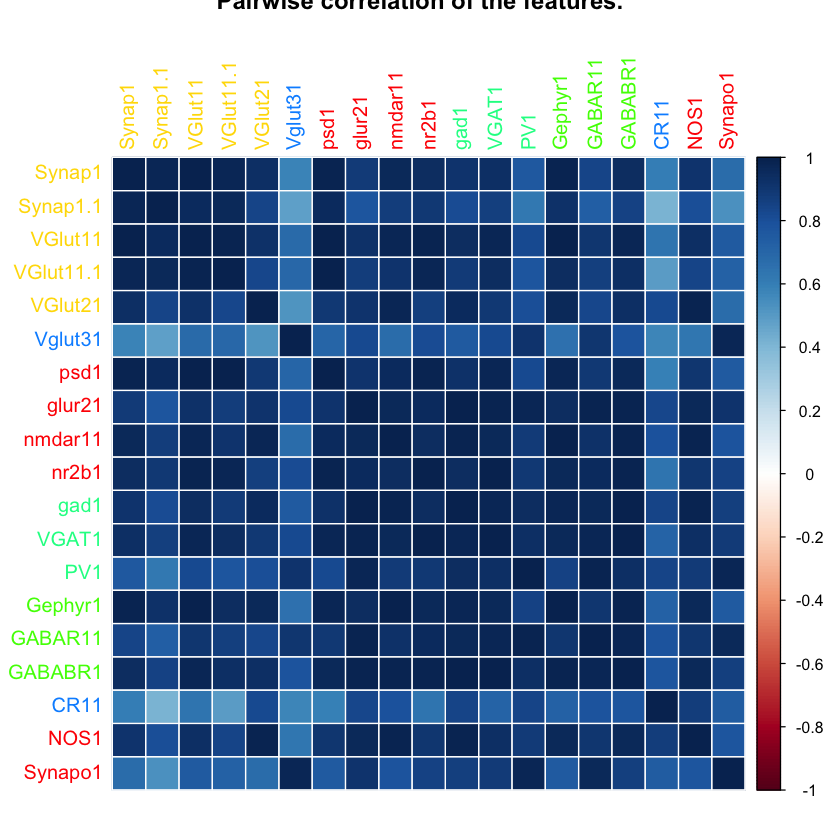

In [32]:
cmat <- cor(feat5)
mn5 <- "Pairwise correlation of the features."
corrplot(cmat,method="color",tl.col=ccol, title=mn5)


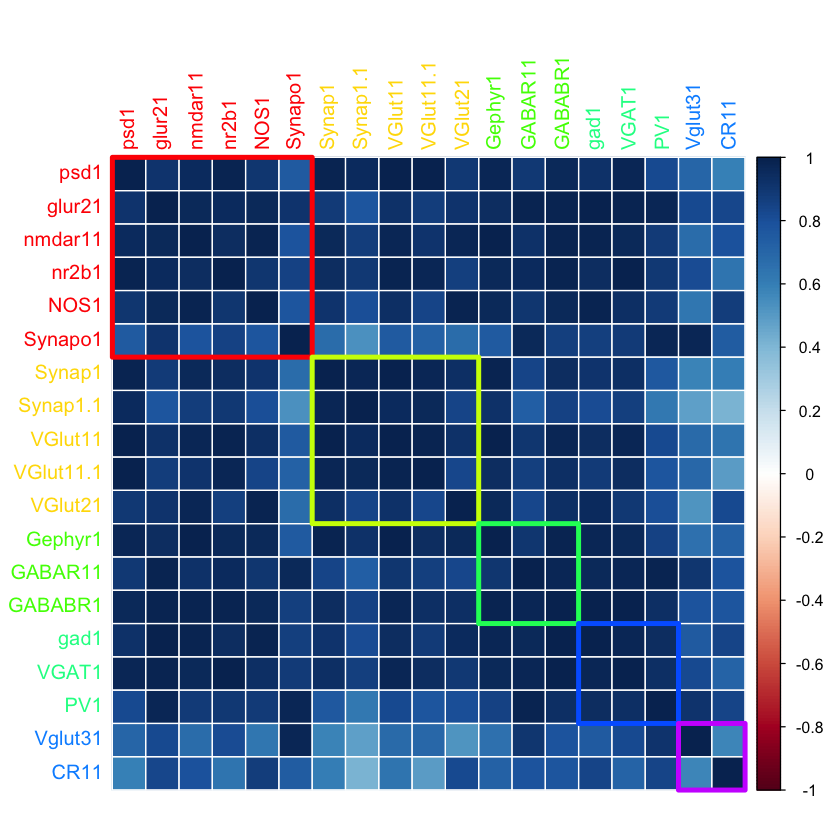

In [33]:
lcol <- rainbow(max(fchannel))
ford <- order(fchannel)
tmp <- as.numeric(table(fchannel))
#plotmemb2(cmat,fchannel,lcol=lcol,lwdb=2)
corrplot(cmat[ford,ford],method="color",tl.col=ccol[ford])
corrRect(tmp,col=lcol,lwd=4)


## Using "scaled" == "z-transformed"

On Feb 10, 2016, at 6:47 AM, jovo Vogelstein <jovo@jhu.edu> wrote:

> i wonder if there are simply too many non-synapses, and their variance
is big, so they are swamping the signal.

> 3) i'm scared of using ZG, pamk, etc.  can we *just* do 2-means on the
"raw" data, where "raw" means z-transformed and only using the 5
groups you did, but no embedding.  and then plot the scaled means plot
and correlations?



In [34]:
kout <- kmeans(zfeat4,2)
lab2 <- kout$cluster
n2 <- as.vector(table(lab2))


 [1] "#00FF92FF" "#00FF92FF" "#00FF92FF" "#49FF00FF" "#FF0000FF" "#49FF00FF"
 [7] "#0092FFFF" "#0092FFFF" "#FF0000FF" "#FFDB00FF" "#FF0000FF" "#FF0000FF"
[13] "#FF0000FF" "#49FF00FF" "#FFDB00FF" "#FF0000FF" "#FFDB00FF" "#FFDB00FF"
[19] "#FFDB00FF"


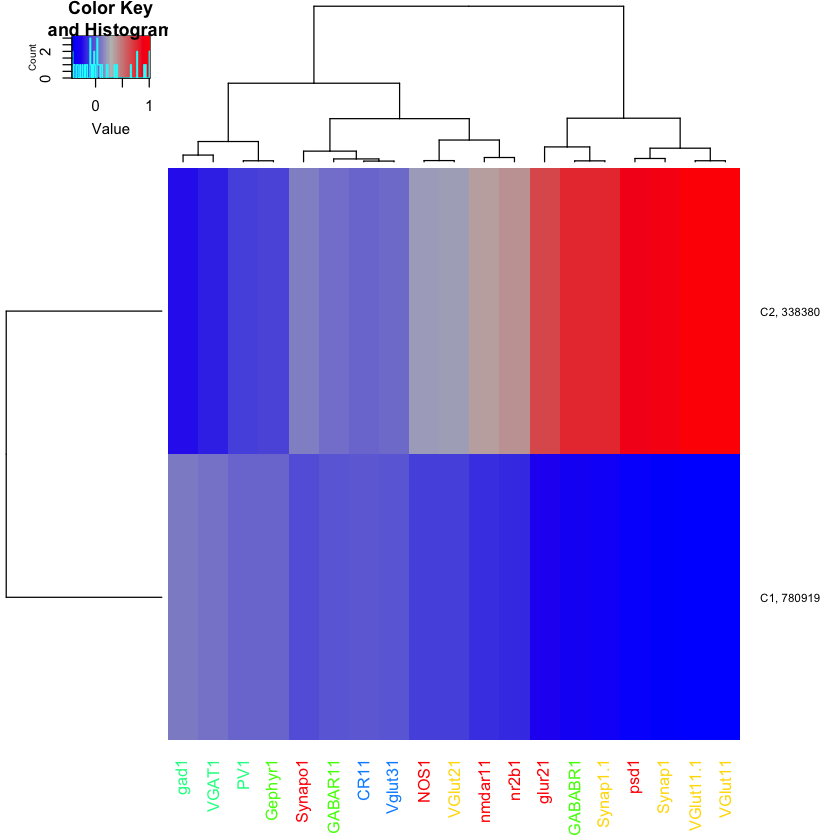

In [35]:
feat6 <- aggregate(zfeat4, by=list(lab=lab2), FUN=mean)
feat6 <- feat6[,-1]
rownames(feat6) <- paste0("C",1:length(n2),", ",n2)
#image(Matrix(as.matrix(feat4)),lwd=0, aspect="fill")

# cluster rows and columns
heatmap.2(as.matrix(feat6), trace="none", col=mycol, keysize=1,cexRow=0.7, colCol=ccol,srtCol=90,
          symm=F,symkey=F,symbreaks=F,scale="none")


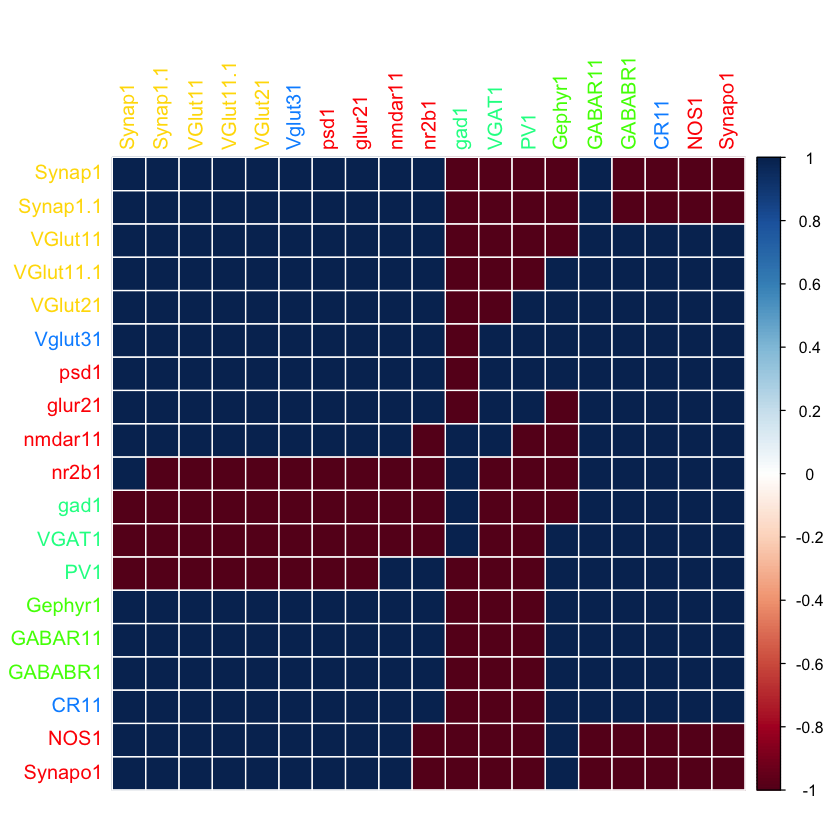

In [36]:
cmat <- cor(feat6)
corrplot(cmat,method="color",tl.col=ccol)

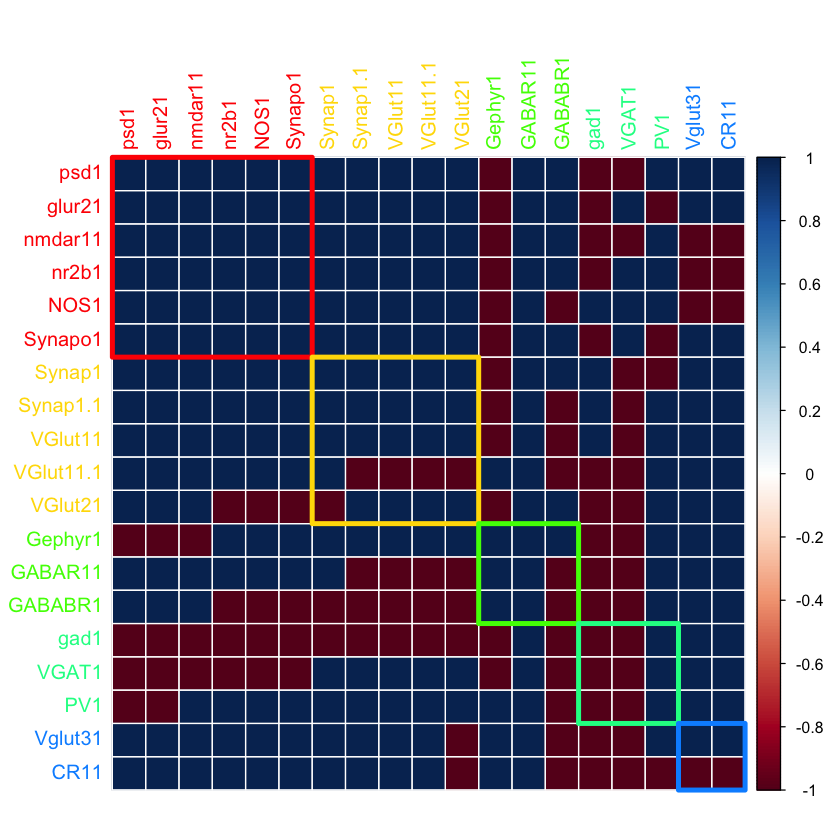

In [37]:
#lcol <- rainbow(max(fchannel))
ford <- order(fchannel)
tmp <- as.numeric(table(fchannel))
#plotmemb2(cmat,fchannel,lcol=lcol,lwdb=2)
corrplot(cmat[ford,ford],method="color",tl.col=ccol[ford])
corrRect(tmp,col=fcol,lwd=4)

